<a href="https://colab.research.google.com/github/caesarcc/pucminas-tcc-fake-news-detection/blob/main/passo05_teste_do_modelo_treinado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treino e Avaliação do Modelo BERTimbau

### Iniciando pela configuração do Google Colab

In [1]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 84.5 MB/s 
     |████████████████████████████████| 6.6 MB 82.6 MB/s 
     |████████████████████████████████| 101 kB 10.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importação de bibliotecas utilizadas no treino e avaliação
import datetime
import os
import random
import time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import display
from sklearn.metrics import (accuracy_score, auc, classification_report, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve,
                             mean_squared_error)
from torch.utils.data import (DataLoader, TensorDataset)
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)
from transformers.file_utils import is_torch_available

In [4]:
#Configurações de ambiente
%matplotlib inline
# limites de impressão para o pandas
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 250)
# configura tema dos gráficos
sns.set_theme(style="white")
#configura a barra de progressos para usar no apply
tqdm.pandas()

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Carrega dados pré-processados

In [5]:
dados = pd.read_csv(r'/content/drive/MyDrive/PUC/TCC/dados/dataset_processado.csv', sep = ',')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6703 entries, 0 to 6702
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   texto             6703 non-null   object
 1   classe            6703 non-null   int64 
 2   texto_limpo       6703 non-null   object
 3   qtde_limpo        6703 non-null   int64 
 4   texto_lematizado  6703 non-null   object
 5   qtde_lematizado   6703 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 314.3+ KB


### Geração de seed  
Rotina para garantir a reprodução dos resultados mesmo que o ambiente for reiniciado.  
Semente aplicada às libs random, numpy e torch.

In [6]:
RANDOM_SEED = 42
def garantir_reprodutividade(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            return "cuda"
    return "cpu"

device = garantir_reprodutividade(RANDOM_SEED)

### Carregando o modelo pré-treinado BERTimbau

In [ ]:
MODELO_LOCAL = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"

MODELO_ORIGEM = "neuralmind/bert-large-portuguese-cased"
# carrega tokenizador
tokenizer = AutoTokenizer.from_pretrained(
    MODELO_ORIGEM, 
    # não altera case, pois o modelo é case-sensitive
    do_lower_case=False
)

# carrega pesos do modelo "BERTimbau"
model_bert = AutoModelForSequenceClassification.from_pretrained(
    MODELO_ORIGEM, 
    num_labels=2          # número de classes da classificação
).to(device)              # coloca o modelo para rodar na GPU

# configura otimizador conforme Huggingfaces
optimizer = torch.optim.AdamW(
    model_bert.parameters(), 
    lr = 1e-5                 # learning rate baixo
)

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

### Tokeniza todos textos para acelerar o treino

In [ ]:
campo_texto = 'texto_lematizado' #'texto_wordcloud_nomes_numeros'
dados_token = dados[['classe', campo_texto]].copy()
dados_token['TOKENS'] = dados_token[campo_texto].progress_apply(
    lambda x: np.array(
        tokenizer.encode(x, padding='max_length', 
                         truncation=True, max_length=300)))
dados_token.rename(columns={'classe':'LABELS'}, inplace=True)

  0%|          | 0/6703 [00:00<?, ?it/s]

### Separa treino, validação e teste e gera datasets de tensoes

In [ ]:
# Separa 60% para treino, 20% para validação e 20% para teste
dados_treino, dados_validacao, dados_teste = np.split(
    dados_token.sample(frac=1), [
      int(.6*len(dados_token)), 
      int(.8*len(dados_token))
])
lote_tamanho = 4

# gera dataset e leitor de dados de treino
treino_dados = TensorDataset(
    torch.tensor(np.array(dados_treino['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_treino['LABELS'].values)).to(device))
treino_leitor = DataLoader(treino_dados, batch_size=lote_tamanho, shuffle=True)

# gera dataset e leitor de dados de validação
validacao_dados = TensorDataset(
    torch.tensor(np.array(dados_validacao['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_validacao['LABELS'].values)).to(device))
validacao_leitor = DataLoader(validacao_dados, batch_size=lote_tamanho, shuffle=True)

# gera dataset e leitor de dados de validação
teste_dados = TensorDataset(
    torch.tensor(np.array(dados_teste['TOKENS'].to_list())).to(device), 
    torch.tensor(np.array(dados_teste['LABELS'].values)).to(device))
teste_leitor = DataLoader(teste_dados, batch_size=lote_tamanho, shuffle=True)

### Método de Avaliação do Modelo

In [ ]:
def avaliar_modelo(modelo, dados):
  modelo.eval() # coloca o modelo em avaliação
  classes_real, classes_pred = [], []
  for idx_lote, lote in enumerate(dados):
    # pega os dados do lote
    lote_valores = lote[0].to(device)
    lote_classes = lote[1].to(device)

    # realiza predição
    outputs = model_bert(lote_valores)    
    # retorna indice de maior valor na predição
    pred_classes = torch.argmax(outputs.logits, 1)
    # salva retorno para medição
    classes_real.extend(lote[1].tolist())
    classes_pred.extend(pred_classes.tolist())

  # Obtem f1, acurácia e loss da validação
  f1 = f1_score(classes_real, classes_pred, average='weighted')
  acuracia = accuracy_score(classes_real, classes_pred)
  loss = mean_squared_error(classes_real, classes_pred)
  return f1, acuracia, loss

### Treinamento Completo

In [ ]:
epocas = 5
lote_status = 32
parar_treino = 2    
max_f1, repetir_treino = 0, 0
estatisticas = []
inicio = time.time()

for epoca in range(0, epocas):
  f1, acc, _ = avaliar_modelo(model_bert, validacao_leitor)
  model_bert.train()
  losses = []
  for idx_lote, lote in enumerate(treino_leitor):
    # pega os dados do lote
    lote_valores = lote[0].to(device)
    lote_classes = lote[1].to(device)

    # treina no lote atual
    output = model_bert(lote_valores, labels=lote_classes)
    # Salva o loss
    loss = output.loss
    losses.append(float(loss))
    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # imprime processo
    if (idx_lote+1) % (lote_status) == 0:
      print("Época: {} [{}/{} ({:.0f}%)]".format(epoca + 1, idx_lote+1, \
        len(treino_leitor), 100. * idx_lote / len(treino_leitor)) \
        + "\tLoss: {:.6f}\tLoss Total: {:.6f}".format(
            float(loss) , round(sum(losses) / len(losses), 5)))
  
  print('Validando...')
  f1, acc, losses_val = avaliar_modelo(model_bert, validacao_leitor)
  print('F1: ', f1, 'Acurácia: ', acc, 'Loss: ', losses_val)

  # grava as estatísticas por época.
  estatisticas.append(
      {
          'epoca': epoca + 1,
          'Loss de Treinamento': round(sum(losses) / len(losses), 5),
          'Loss de Validação': round(losses_val, 5),
          'F1': round(f1, 5),
          'Acurácia de Validação': round(acc, 5)
      }
  )

  if f1 > max_f1:
    model_bert.save_pretrained(MODELO_LOCAL)
    max_f1 = f1
    repeat = 0
    print('Salvando melhor modelo...')
  else:
    repetir_treino += 1
  if repetir_treino == parar_treino:
    break

print("Tempo total do treino {:} (h:mm:ss)".format(format_time(time.time()-inicio)))

Época: 1 [32/1006 (3%)]	Loss: 0.624921	Loss Total: 0.667690
Época: 1 [64/1006 (6%)]	Loss: 0.486644	Loss Total: 0.595100
Época: 1 [96/1006 (9%)]	Loss: 0.138586	Loss Total: 0.527290
Época: 1 [128/1006 (13%)]	Loss: 0.183561	Loss Total: 0.482800
Época: 1 [160/1006 (16%)]	Loss: 0.293256	Loss Total: 0.448590
Época: 1 [192/1006 (19%)]	Loss: 0.211693	Loss Total: 0.416430
Época: 1 [224/1006 (22%)]	Loss: 0.092114	Loss Total: 0.394900
Época: 1 [256/1006 (25%)]	Loss: 0.660646	Loss Total: 0.400690
Época: 1 [288/1006 (29%)]	Loss: 0.143826	Loss Total: 0.394190
Época: 1 [320/1006 (32%)]	Loss: 0.154520	Loss Total: 0.378420
Época: 1 [352/1006 (35%)]	Loss: 0.089995	Loss Total: 0.364260
Época: 1 [384/1006 (38%)]	Loss: 0.022473	Loss Total: 0.353020
Época: 1 [416/1006 (41%)]	Loss: 0.024034	Loss Total: 0.337380
Época: 1 [448/1006 (44%)]	Loss: 0.185195	Loss Total: 0.324180
Época: 1 [480/1006 (48%)]	Loss: 0.023557	Loss Total: 0.312940
Época: 1 [512/1006 (51%)]	Loss: 0.058276	Loss Total: 0.310280
Época: 1 [544/

### Gera as estatísticas do treino

In [ ]:
# Cria um dataframe das estatísticas
pd.set_option('precision', 3)
df_estatisticas = pd.DataFrame(data=estatisticas)
df_estatisticas = df_estatisticas.set_index('epoca')

### Curva de aprendizado

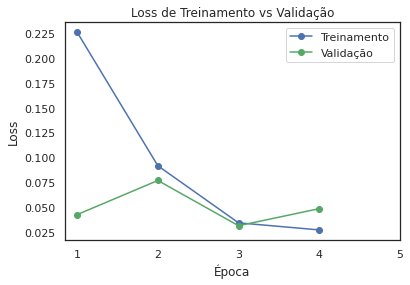

In [ ]:
plt.figure()
# Mostra curva de aprendizado.
plt.plot(df_estatisticas['Loss de Treinamento'], 'b-o', label="Treinamento")
plt.plot(df_estatisticas['Loss de Validação'], 'g-o', label="Validação")
plt.title("Loss de Treinamento vs Validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()

### Acurácia

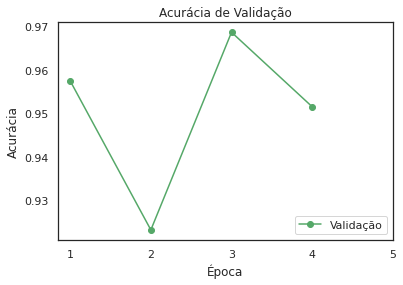

In [ ]:
plt.figure()
plt.plot(df_estatisticas['Acurácia de Validação'], 'g-o', label="Validação")
plt.title("Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

### Teste do Modelo tunado

In [ ]:
classes_previstas , classes_verdadeiras = [], []

MODELO_LOCAL = "/content/drive/MyDrive/PUC/TCC/modelos/classificador_bertimbau"

tokenizer = AutoTokenizer.from_pretrained(MODELO_LOCAL, do_lower_case=False)
model_bert = AutoModelForSequenceClassification.from_pretrained(MODELO_ORIGEM, num_labels=2)
model_bert.to(device)

for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device) for t in lote)
    lote_valores, lote_classes = lote
    with torch.no_grad():
        outputs = model_bert(lote_valores)
    # Adiciona as prediões e as classes para a CPU
    outputs = outputs.logits.detach().cpu().numpy()
    classes = lote_classes.to('cpu').numpy()
    # Salva as predições e as classes corretos
    classes_previstas.append(outputs)
    classes_verdadeiras.append(classes) 

# prepara resultado
lista_previsoes = np.concatenate(classes_previstas, axis=0)
lista_previsoes = np.argmax(lista_previsoes, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

### Relatório de classificação

In [ ]:
print(classification_report(
    lista_classes_verdadeiras, 
    lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.94      0.99      0.97       675
       falso       0.99      0.94      0.96       666

    accuracy                           0.96      1341
   macro avg       0.97      0.96      0.96      1341
weighted avg       0.97      0.96      0.96      1341



### Matriz de confusão

[[667   8]
 [ 40 626]]


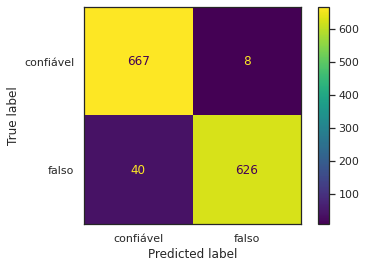

In [ ]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Curva ROC
Receiver Operating Characteristic Curve

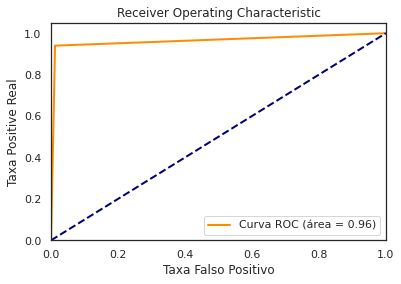

In [ ]:
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()